In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import glob
import matplotlib
import matplotlib.pyplot as plt
import dask
from datetime import datetime

In [2]:
# Updated for PBS scheduler
# this could go into utils.
# By default gets 1 core w/ 25 GB memory
def get_ClusterClient(ncores=1, nmem='25GB'):
    import dask
    from dask_jobqueue import PBSCluster
    from dask.distributed import Client
    ncores=ncores
    nmem = nmem

    cluster = PBSCluster(
        cores=ncores, # The number of cores you want
        memory=nmem, # Amount of memory
        processes=ncores, # How many processes
        queue='casper', # The type of queue to utilize (/glade/u/apps/dav/opt/usr/bin/execcasper)
        resource_spec='select=1:ncpus='+str(ncores)+':mem='+nmem, # Specify resources
        project='P93300641', # Input your project ID here
        walltime='1:00:00', # Amount of wall time
        interface='ib0', # Interface to use
    )

    client = Client(cluster)
    return cluster, client

In [3]:
cluster, client = get_ClusterClient()
cluster.scale(20)

/glade/work/djk2120/miniconda3/envs/lens-py/lib/python3.7/site-packages/distributed/node.py:155: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 35915 instead
  http_address["port"], self.http_server.port


In [18]:
client

Client Scheduler: tcp://10.12.206.54:37348 Dashboard: https://https://jupyterhub.hpc.ucar.edu/stable/user/djk2120/proxy/{port}/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


### inspect fsurdat

In [3]:
thedir = '/glade/p/cesmdata/cseg/inputdata/lnd/clm2/surfdata_map/ctsm5.1.dev052/'
f      = thedir+'surfdata_360x720cru_hist_78pfts_CMIP6_simyr1700_c210820.nc'
ds = xr.open_dataset(f)

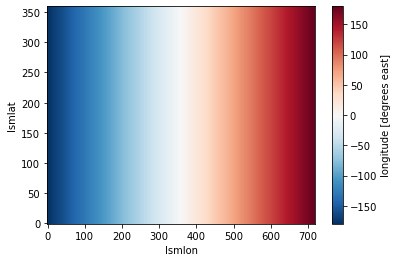

In [9]:
ds.LONGXY.plot()

### inspect the streamfiles

In [6]:
dir1 = '/glade/p/cgd/tss/CTSM_datm_forcing_data/atm_forcing.datm7.CRUJRA.0.5d.v1.c190604/'
dir2 = '/glade/scratch/djk2120/ctsm_trendy_2021/forcing/three_stream/'

In [21]:
f = 'clmforc.CRUJRAV1.1.c2019.0.5x0.5.TPQWL.2000-01.nc'
ds0 = xr.open_dataset(dir1+f)
t0 = ds0.TBOT.mean(dim='time')

In [38]:
f = 'clmforc.TRENDY.c2021_0.5x0.5.TPQWL.2000.nc'
ds = xr.open_dataset(dir2+f)
ixt = ds['time.month']==1
t = ds.TBOT.isel(time=ixt).mean(dim='time')

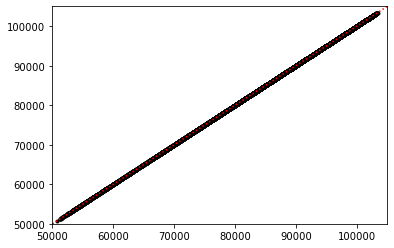

In [40]:
p0 = ds0.PSRF.mean(dim='time')
p  = ds.PSRF.isel(time=ixt).mean(dim='time')
plt.plot(p,p0,'k.')
plt.xlim([50000,105000])
plt.ylim([50000,105000])
plt.plot([50000,105000],[50000,105000],'r:');

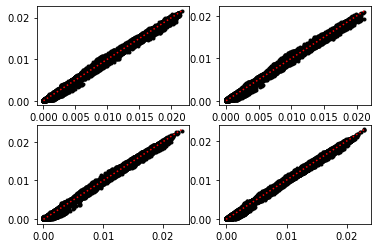

In [75]:
month = 1
year = 1901
day = 1


f1 = 'clmforc.CRUJRAV1.1.c2019.0.5x0.5.TPQWL.'+str(year)+'-'+str(month).zfill(2)+'.nc'
f2 = 'clmforc.TRENDY.c2021_0.5x0.5.TPQWL.'+str(year)+'.nc'
ds1 = xr.open_dataset(dir1+f1)
ds2 = xr.open_dataset(dir2+f2)

ixt1 = ds1['time.day']==day
ixt2 = np.logical_and(ds2['time.month']==month,ds2['time.day']==day)

thisvar = 'QBOT'
x1  = ds1[thisvar].isel(time=ixt1)
x2  = ds2[thisvar].isel(time=ixt2)
for i in range(4):
    x11 = x1.isel(time=i)
    x22 = x2.isel(time=i)
    xmin = x11.min()
    xmax = x11.max()
    ix = x22>0
    plt.subplot(2,2,i+1)
    plt.plot(x11.where(ix),x22.where(ix),'k.')
    plt.plot([xmin,xmax],[xmin,xmax],'r:')


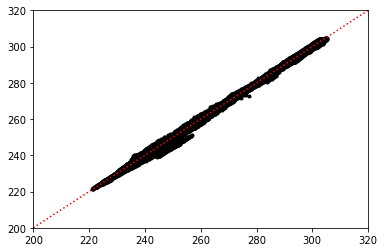

In [26]:
plt.plot(t0,t,'k.')
plt.plot([200,320],[200,320],'r:')
plt.xlim([200,320])
plt.ylim([200,320]);

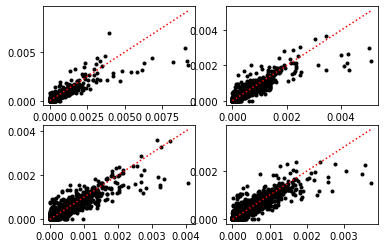

In [82]:
month = 7
year = 1981
day = 1

f1 = 'clmforc.CRUJRAV1.1.c2019.0.5x0.5.Prec.'+str(year)+'-'+str(month).zfill(2)+'.nc'
f2 = 'clmforc.TRENDY.c2021_0.5x0.5.Prec.'+str(year)+'.nc'
ds1 = xr.open_dataset(dir1+f1)
ds2 = xr.open_dataset(dir2+f2)

ixt1 = ds1['time.day']==day
ixt2 = np.logical_and(ds2['time.month']==month,ds2['time.day']==day)

thisvar = 'PRECTmms'
x1  = ds1[thisvar].isel(time=ixt1)
x2  = ds2[thisvar].isel(time=ixt2)
for i in range(4):
    x11 = x1.isel(time=i)
    x22 = x2.isel(time=i)
    xmin = x11.min()
    xmax = x11.max()
    ix = x22>0
    plt.subplot(2,2,i+1)
    plt.plot(x11.where(ix),x22.where(ix),'k.')
    plt.plot([xmin,xmax],[xmin,xmax],'r:')

In [13]:
year=1966
dir2 = '/glade/scratch/djk2120/ctsm_trendy_2021/forcing/three_stream/'
f2 = 'clmforc.TRENDY.c2021_0.5x0.5.Solr.'+str(year)+'.nc'
ds2 = xr.open_dataset(dir2+f2,chunks={'time':20})

In [17]:
f = '/glade/scratch/djk2120/ctsm_trendy_2021/forcing/three_stream/domain.crujra_v2.2_0.5x0.5.c210804.nc'
ds0 = xr.open_dataset(f)

In [19]:
i=3
lats = np.tile(ds2.lat.values.reshape(-1,1),[1,720])
lons = np.tile(ds2.lon.values,[360,1])
fsds = ds2.FSDS_DIRECT.isel(time=i)

In [20]:
x    = fsds.values[ds0.mask.values==1]
nnan = np.sum(np.isnan(x))

ix = (np.isnan(fsds.values))&(ds0.mask.values==1)
 

In [21]:
lats[ix]
lons[ix]

array([], dtype=float32)

In [20]:
ix = ds2['time.month']==1
jan = ds2.FSDS_DIRECT.isel(time=ix)

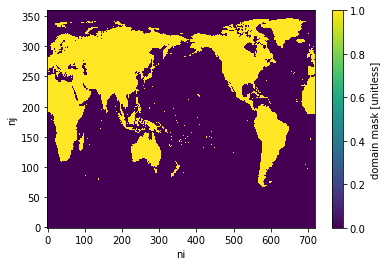

In [28]:
ds0.mask.plot()

In [45]:
month = 1
year = 1966


f1 = 'clmforc.CRUJRAV1.1.c2019.0.5x0.5.TPQWL.'+str(year)+'-'+str(month).zfill(2)+'.nc'

ds1 = xr.open_dataset(dir1+f1)

In [100]:
dir1='/glade/scratch/djk2120/ctsm_trendy_2021/forcing/met/'
f1='tswrf_v10_1966.nc'
ds = xr.open_dataset(dir1+f1)

In [108]:
tswrf=ds.tswrf.isel(time=3)

In [113]:
ix1 = np.isnan(tswrf)

In [115]:
ix2 = (ds0.mask==1)

In [ ]:
ix = (ix1)&(ix2)

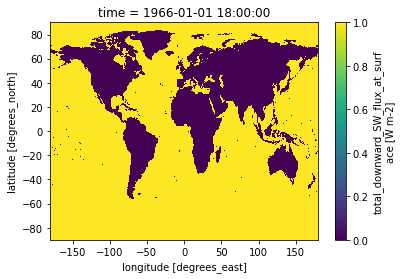

In [114]:
ix1.plot()

(360, 720)

(360, 720)

In [82]:

print(lats[ix],lons[ix])

[0.25] [6.25]


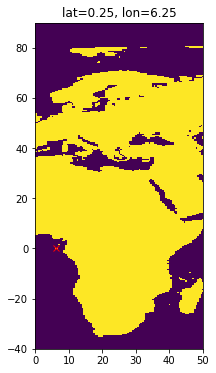

In [80]:
plt.figure(figsize=[3,6])
plt.pcolormesh(ds2.lon,ds2.lat,ds0.mask,shading='auto')
plt.plot(lons[ix],lats[ix],'rx')
plt.xlim([0,50])
plt.ylim([-40,90])
plt.title('lat='+str(lats[ix][0])+', lon='+str(lons[ix][0]));

In [40]:
for i in range(124):
    x=jan.isel(time=i).values[ds0.mask.values==1]
    print(i,np.sum(np.isnan(x)))

0 0
1 0
2 0
3 1
4 0
5 0
6 1
7 1
8 1
9 1
10 1
11 1
12 1
13 1
14 1
15 1
16 1
17 0
18 0
19 1
20 0
21 0
22 0
23 1
24 0
25 0
26 0
27 1
28 1
29 0
30 0
31 1
32 0
33 0
34 0
35 1
36 1
37 1
38 0
39 1
40 1
41 1
42 1
43 1
44 1
45 0
46 0
47 1
48 1
49 0
50 0
51 1
52 0
53 0
54 1
55 1
56 0
57 0
58 1
59 1
60 1
61 1
62 1
63 1
64 1
65 1
66 1
67 1
68 0
69 1
70 0
71 1
72 1
73 1
74 1
75 1
76 1
77 0
78 0
79 1
80 1
81 1
82 1
83 1
84 0
85 1
86 1
87 1
88 0
89 0
90 0
91 1
92 0
93 0
94 0
95 1
96 0
97 0
98 0
99 1
100 0
101 0
102 0
103 1
104 1
105 1
106 1
107 1
108 0
109 1
110 1
111 1
112 1
113 1
114 1
115 1
116 1
117 1
118 1
119 1
120 1
121 1
122 0
123 1


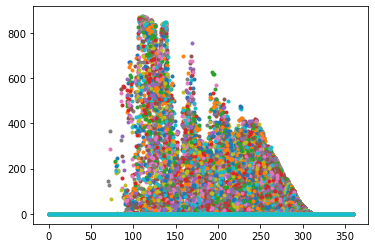

In [24]:
plt.plot(jan.isel(time=0),'.');

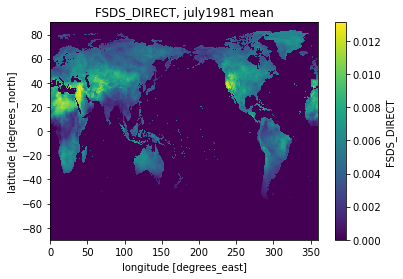

In [28]:
ix = ds2['time.month']==7
ds2.FSDS_DIRECT.isel(time=ix).mean(dim='time').plot()
plt.title('FSDS_DIRECT, july1981 mean');

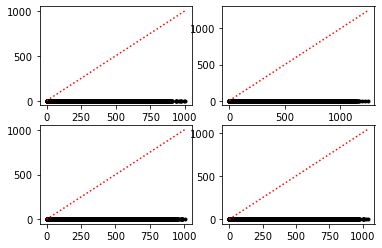

In [5]:
var1 = 'FSDS'
var2 = 'FSDS_DIRECT'
var3 = 'FSDS_DIFFUSE'
x1  = ds1[var1].isel(time=ixt1)
x2  = (ds2[var2]+ds2[var3]).isel(time=ixt2)
for i in range(4):
    x11 = x1.isel(time=i)
    x22 = x2.isel(time=i)
    xmin = x11.min()
    xmax = x11.max()
    ix = x22>0
    plt.subplot(2,2,i+1)
    plt.plot(x11.where(ix),x22.where(ix),'k.')
    plt.plot([xmin,xmax],[xmin,xmax],'r:')

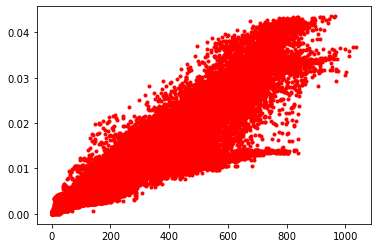

In [17]:
plt.plot(x11.where(ix),x22.where(ix),'r.');

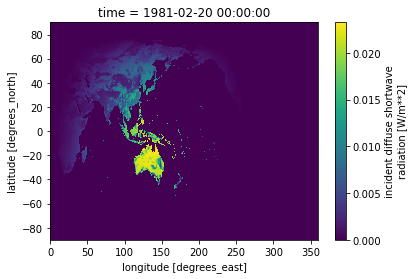

In [14]:
ds2.FSDS_DIFFUSE.isel(time=200).plot()

In [29]:
f4 = '/glade/scratch/djk2120/ctsm_trendy_2021/forcing/met/fd_v10_1932.nc'
ds4 = xr.open_dataset(f4)

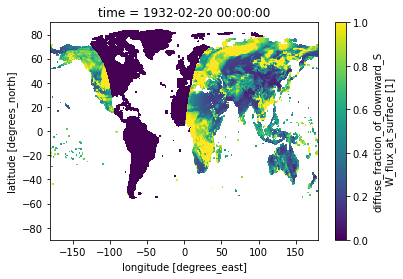

In [32]:
ds4.fd.isel(time=200).plot()

In [18]:
f3 = '/glade/scratch/djk2120/ctsm_trendy_2021/forcing/met/tswrf_v10_1981.nc'
ds3 = xr.open_dataset(f3)

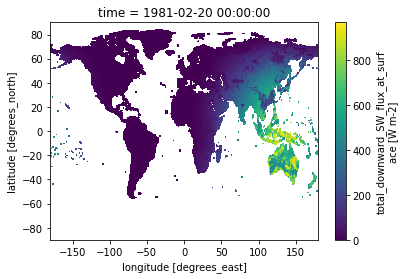

In [23]:
ds3.tswrf.isel(time=200).plot()

### check that the masks align

In [25]:
ds0 = xr.open_dataset('/glade/scratch/djk2120/ctsm_trendy_2021/forcing/three_stream/domain.crujra_v2.2_0.5x0.5.c210804.nc')


In [4]:
ds1 = xr.open_dataset('/glade/scratch/djk2120/ctsm_trendy_2021/forcing/met/crujra.v2.2.5d.pres.2020.365d.noc.nc')

In [5]:
ds2 = xr.open_dataset('/glade/scratch/djk2120/ctsm_trendy_2021/forcing/met/tswrf_v10_2020.nc')

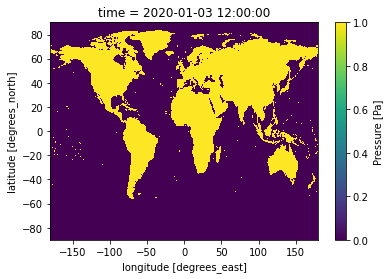

In [21]:
(~np.isnan(ds1.pres.isel(time=10))).plot()

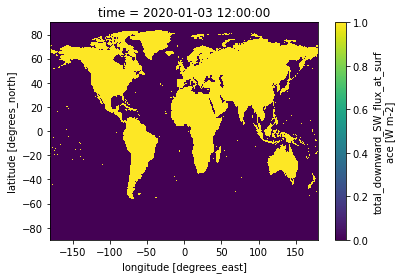

In [31]:
x=(~np.isnan(ds2.tswrf.isel(time=10)))
x.plot()

In [33]:
x[:,:360]

<xarray.DataArray 'tswrf' (lat: 360, lon: 360)>
array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])
Coordinates:
  * lat      (lat) float32 -89.75 -89.25 -88.75 -88.25 ... 88.75 89.25 89.75
  * lon      (lon) float32 -179.8 -179.2 -178.8 -178.2 ... -1.25 -0.75 -0.25
    time     object 2020-01-03 12:00:00
Attributes:
    cell_methods:   time: mean
    long_name:      total_downward_SW_flux_at_surface
    standard_name:  total_downward_SW_flux_at_surface
    units:          W m-2

In [34]:
y=ds0.mask

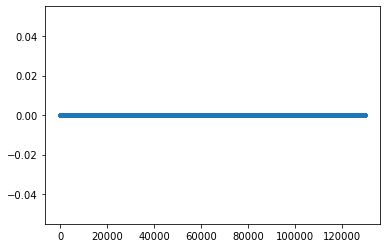

In [37]:
x2=x[:,:360].values.ravel()
y2=y[:,360:].values.ravel()
plt.plot(x2-y2,'.')

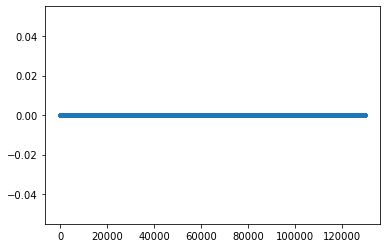

In [39]:
x2=x[:,360:].values.ravel()
y2=y[:,:360].values.ravel()
plt.plot(x2-y2,'.')

In [44]:
d = '/glade/scratch/djk2120/ctsm_trendy_2021/forcing/ndep/'
f = 'drynhx_input4MIPs_surfaceFluxes_CMIP_hist_ssp585_NCAR-CCMI-2-0_gn_185001-209912.720x360.nc'
ds = xr.open_dataset(d+f,decode_times=False)

In [47]:
f = '/glade/p/cgd/tss/people/dll/TRENDY2019_Forcing/Ndep/TRENDY2019_Ndep_Monthly_c190821.nc'
ds2 = xr.open_dataset(f)

In [50]:
ds2

<xarray.Dataset>
Dimensions:                  (lat: 192, lon: 288, nbnd: 2, time: 3000)
Coordinates:
  * lat                      (lat) float64 -90.0 -89.06 -88.12 ... 89.06 90.0
  * lon                      (lon) float64 0.0 1.25 2.5 ... 356.2 357.5 358.8
  * time                     (time) object 1850-01-16 12:00:00 ... 2099-12-16...
Dimensions without coordinates: nbnd
Data variables:
    gw                       (lat) float64 3.382e-05 0.0002705 ... 3.382e-05
    date                     (time) float64 1.85e+07 1.85e+07 ... 2.099e+07
    time_bnds                (time, nbnd) object 1850-01-01 00:00:00 ... 2100...
    dry_deposition_NHx_as_N  (time, lat, lon) float32 ...
    dry_deposition_NOy_as_N  (time, lat, lon) float32 ...
    wet_deposition_NHx_as_N  (time, lat, lon) float32 ...
    wet_deposition_NOy_as_N  (time, lat, lon) float32 ...
    datesec                  (time) int32 0 0 0 ... -2147483647 -2147483647
    NDEP_NOy_month           (time, lat, lon) float32 ...
    NDEP_NHx_month           (time, lat, lon) float32 ...
    NDEP_month               (time, lat, lon) float32 ...
Attributes:
    Conventions:               CF-1.0
    source:                    CAM
    case:                      b.e21.BWHIST.f09_g17.CMIP6-historical-WACCM.00...
    logname:                   cmip6
    host:                      cheyenne1
    initial_file:              b.e21.BW1850.f09_g17.CMIP6-piControl.001.cam.i...
    topography_file:           /glade/p/cesmdata/cseg/inputdata/atm/cam/topo/...
    model_doi_url:             https://doi.org/10.5065/D67H1H0V
    time_period_freq:          month_1
    history:                   
    NCO:                       netCDF Operators version 4.7.4 (http://nco.sf....
    nco_openmp_thread_number:  1
    source_data:               \nEnsemble mean of linearly interpolated 5 yea...
    creation_date:             \nWed Sep 26 12:11:25 MDT 2018
    cesm_contact:              \nKeith Oleson, NCAR CGD, oleson@ucar.edu
    data_script:               \nConverted from data_source_files by program ...
    comment:                   1849 and 1850 data are from 1850 WACCM simulat...

### prepare the co2 file

In [17]:
f = '/glade/scratch/djk2120/ctsm_trendy_2021/forcing/co2/global_co2_ann_1700_2020.txt'
co2=pd.read_csv(f,header=None,sep="  ",)
co2_from_trendy = co2[1].values

/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  


In [18]:
f = '/glade/p/cgd/tss/people/dll/TRENDY2020_Forcing/fco2_datm_global_simyr_1750-2014_CMIP6_c180929.nc'
ds1 = xr.open_dataset(f,decode_times=False)

In [19]:
#need to append one more datapoint to the dataset
ds2 = ds1.isel(time=0).copy(deep=True)
ds2['time']=ds1.time[-1]+365

In [20]:
ds3 = xr.concat([ds1,ds2],dim='time')
ds3['CO2'][:]=co2_from_trendy[:,np.newaxis,np.newaxis]

In [21]:
date = datetime.now().strftime("%m/%d/%Y %H:%M")
hist_str = date+': convert by trendy2021.ipynb'
ds3.attrs={'history':hist_str,'creation_date':date,
              'source':'converted from TRENDYs global_co2_ann_1700_2020.txt',
              'creator':'Daniel Kennedy, djk2120@ucar.edu'}

In [23]:
#take originals, the concat adds a time dimension where it shouldnt
for v in ds1.data_vars:
    if 'time' not in ds1[v].coords:
        ds3.drop(v)
        ds3[v]=ds1[v]

In [25]:
ds3.to_netcdf('/glade/scratch/djk2120/ctsm_trendy_2021/forcing/co2/fco2_datm_global_simyr_1700-2020_TRENDY_c210825.nc')

### edit the ndep files

In [68]:
f = glob.glob('/glade/scratch/djk2120/ctsm_trendy_2021/forcing/ndep/*.nc')
ds2 = xr.open_mfdataset(f,combine='nested',decode_times=False)

['/glade/scratch/djk2120/ctsm_trendy_2021/forcing/ndep/drynoy_input4MIPs_surfaceFluxes_CMIP_hist_ssp585_NCAR-CCMI-2-0_gn_185001-209912.720x360.nc',
 '/glade/scratch/djk2120/ctsm_trendy_2021/forcing/ndep/wetnhx_input4MIPs_surfaceFluxes_CMIP_hist_ssp585_NCAR-CCMI-2-0_gn_185001-209912.720x360.nc',
 '/glade/scratch/djk2120/ctsm_trendy_2021/forcing/ndep/drynhx_input4MIPs_surfaceFluxes_CMIP_hist_ssp585_NCAR-CCMI-2-0_gn_185001-209912.720x360.nc',
 '/glade/scratch/djk2120/ctsm_trendy_2021/forcing/ndep/wetnoy_input4MIPs_surfaceFluxes_CMIP_hist_ssp585_NCAR-CCMI-2-0_gn_185001-209912.720x360.nc']

In [52]:
f = '/glade/p/cgd/tss/people/dll/TRENDY2019_Forcing/Ndep/TRENDY2019_Ndep_Monthly_c190821.nc'
ds = xr.open_dataset(f)

In [73]:
ndep = xr.Dataset()
clm_names = ['dry_deposition_NHx_as_N','dry_deposition_NOy_as_N','wet_deposition_NHx_as_N','wet_deposition_NOy_as_N']
trn_names = ['drynhx','drynoy','wetnhx','wetnoy']

for clm,trn in zip(clm_names,trn_names):
    ndep[clm]=ds2[trn].copy(deep=True)
    

In [90]:
noy = 'NDEP_NOy_month'
ndep[noy] = 1000*(ds2.drynoy+ds2.wetnoy).copy(deep=True)
ndep[noy].attrs = ds[noy].attrs

nhx = 'NDEP_NHx_month'
ndep[nhx] = 1000*(ds2.drynhx+ds2.wetnhx).copy(deep=True)
ndep[nhx].attrs = ds[nhx].attrs

ntot = 'NDEP_month'
ndep[ntot] = ndep[noy]+ndep[nhx]
ndep[ntot].attrs = ds[ntot].attrs

ndep['time']=ds['time'].copy(deep=True)

In [114]:
thedir = '/glade/scratch/djk2120/ctsm_trendy_2021/forcing/ndep/'
nfile  = thedir+'TRENDY2021_Ndep_Monthly_c210817.nc'
ndep['dry_deposition_NHx_as_N'].to_netcdf(nfile)

In [127]:
appends = list(ndep.data_vars)
appends.remove('dry_deposition_NHx_as_N')
appends

['dry_deposition_NOy_as_N',
 'wet_deposition_NHx_as_N',
 'wet_deposition_NOy_as_N',
 'NDEP_NOy_month',
 'NDEP_NHx_month',
 'NDEP_month']

In [128]:
for thisvar in appends:
    print(thisvar)
    ndep[thisvar].to_netcdf(nfile,'a')

dry_deposition_NOy_as_N
wet_deposition_NHx_as_N
wet_deposition_NOy_as_N
NDEP_NOy_month
NDEP_NHx_month
NDEP_month


In [144]:
da = ds.datesec.copy(deep=True)
da[:]=0
ndep['datesec'] = da.copy(deep=True)

In [145]:
ndep['date']=ds['date'].copy(deep=True)

In [149]:
gw = np.cos(ndep.lat/360*2*np.pi)
gw = 2*gw/gw.sum()
ndep['gw'] = xr.DataArray(gw,dims='lat')

In [162]:
appends = ['date','datesec','gw']
for thisvar in appends:
    print(thisvar)
    ndep[thisvar].to_netcdf(nfile,'a')

date
datesec
gw


In [163]:
tmp = xr.open_dataset('/glade/scratch/djk2120/ctsm_trendy_2021/forcing/ndep/tmp3.nc')

In [164]:
tmp

<xarray.Dataset>
Dimensions:                  (lat: 360, lon: 720, time: 3000)
Coordinates:
  * time                     (time) object 1850-01-16 12:00:00 ... 2099-12-16...
  * lon                      (lon) float64 -179.8 -179.2 -178.8 ... 179.2 179.8
  * lat                      (lat) float64 -89.75 -89.25 -88.75 ... 89.25 89.75
Data variables:
    dry_deposition_NHx_as_N  (time, lat, lon) float32 ...
    dry_deposition_NOy_as_N  (time, lat, lon) float32 ...
    wet_deposition_NHx_as_N  (time, lat, lon) float32 ...
    wet_deposition_NOy_as_N  (time, lat, lon) float32 ...
    NDEP_NOy_month           (time, lat, lon) float32 ...
    NDEP_NHx_month           (time, lat, lon) float32 ...
    NDEP_month               (time, lat, lon) float32 ...
    date                     (time) float64 ...
    datesec                  (time) int32 ...
    gw                       (lat) float64 ...

In [177]:
ix = ds['time.year']==2016
ds.datesec[ix]

<xarray.DataArray 'datesec' (time: 12)>
array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)
Coordinates:
  * time     (time) object 2016-01-16 12:00:00 ... 2016-12-16 12:00:00
Attributes:
    long_name:  current seconds of current date